<a href="https://colab.research.google.com/github/csagor21/Covid19_detection_Using_CNN/blob/main/COVID19_Detection_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
pip install grad-cam

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import zipfile
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, models
from sklearn.metrics import classification_report, confusion_matrix
import random
from PIL import Image
import shap
import cv2
from torch.cuda.amp import GradScaler, autocast
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image as show_cam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [31]:
# Step 1: Extract Dataset
zip_path = "/content/drive/MyDrive/archive (1).zip"
unzip_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

dataset_path = os.path.join(unzip_path, "Covid19-dataset")

In [32]:
# Step 2: Define Transforms for Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [33]:
# Step 3: Load Dataset
train_data = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
test_data = datasets.ImageFolder(root=os.path.join(dataset_path, "test"), transform=transform)

In [34]:
# Step 3.1: Class Balancing using Weighted Sampler
class_counts = np.bincount([label for _, label in train_data])
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_data]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_data, batch_size=64, sampler=sampler, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [35]:
# Step 4: Use GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

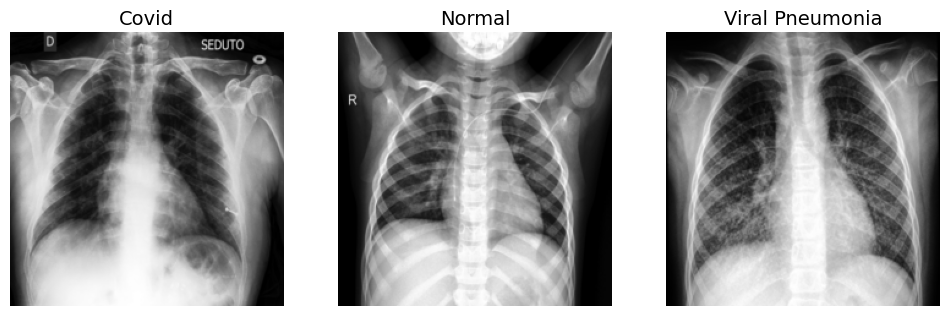

In [36]:
# Re-import necessary libraries after execution reset
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# Assuming train_data needs to be reloaded after execution reset
# Define dataset path (modify based on your actual dataset location)
dataset_path = "/content/dataset/Covid19-dataset/train"  # Adjust as necessary

# Define transformation (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
])

# Load dataset
train_data = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create a figure with 3 subplots for each class
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Adjusting figure size for better layout
class_names = train_data.classes
selected_images = {class_name: None for class_name in class_names}

# Select one image per class
for image, label in train_data:
    class_name = class_names[label]
    if selected_images[class_name] is None:
        selected_images[class_name] = (image, label)
    if all(selected_images.values()):  # Stop when we have one image per class
        break

# Display selected images correctly
for i, (class_name, (image, label)) in enumerate(selected_images.items()):
    image = image.numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

    # Check if the image has 3 channels (RGB) or 1 channel (Grayscale)
    if image.shape[2] == 1:
        image = image.squeeze(axis=2)  # Convert from (H, W, 1) to (H, W) for grayscale

    # Normalize the image for display
    image = (image - image.min()) / (image.max() - image.min())

    # Show image with correct colormap
    cmap = "gray" if len(image.shape) == 2 else None
    axes[i].imshow(image, cmap=cmap)
    axes[i].set_title(class_name, fontsize=14)
    axes[i].axis('off')



<ipython-input-37-f629084507c1>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='Blues')


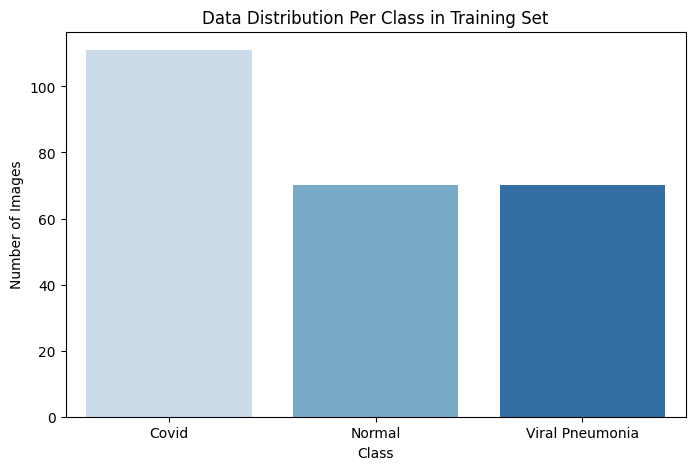

In [37]:
# Step 4.1: Plot Data Distribution
class_counts = {class_name: 0 for class_name in class_names}
for _, label in train_data:
    class_counts[class_names[label]] += 1

plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='Blues')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Data Distribution Per Class in Training Set")
plt.show()

In [38]:
# Step 5: Define Pretrained Model (ResNet18) for Comparison
pretrained_model = models.resnet18(pretrained=True)
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, len(train_data.classes))
pretrained_model = pretrained_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training resnet18...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1, Loss: 0.84227354824543
Epoch 2, Loss: 0.40278127789497375
Epoch 3, Loss: 0.31335970759391785
Epoch 4, Loss: 0.2861288748681545
Epoch 5, Loss: 0.2261374332010746
Epoch 6, Loss: 0.1636248119175434
Accuracy of resnet18: 0.7879
Training vgg16...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker n

Epoch 1, Loss: 2.441275119781494
Epoch 2, Loss: 1.2286229133605957
Epoch 3, Loss: 1.1720801889896393
Epoch 4, Loss: 1.1467852592468262
Epoch 5, Loss: 1.0949237942695618
Epoch 6, Loss: 1.1287547945976257
Accuracy of vgg16: 0.3939
Training mobilenet_v2...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torchvisi

Epoch 1, Loss: 0.6456103548407555
Epoch 2, Loss: 0.30765610560774803
Epoch 3, Loss: 0.262888316065073
Epoch 4, Loss: 0.1774611473083496
Epoch 5, Loss: 0.22444858588278294
Epoch 6, Loss: 0.15641077235341072
Accuracy of mobilenet_v2: 0.7727
          Model  Accuracy  Precision    Recall  F1-Score
0      resnet18  0.787879   0.875223  0.787879  0.782375
1         vgg16  0.393939   0.155188  0.393939  0.222661
2  mobilenet_v2  0.772727   0.870130  0.772727  0.735537
Best model: resnet18 with accuracy 0.7879


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix for resnet18')

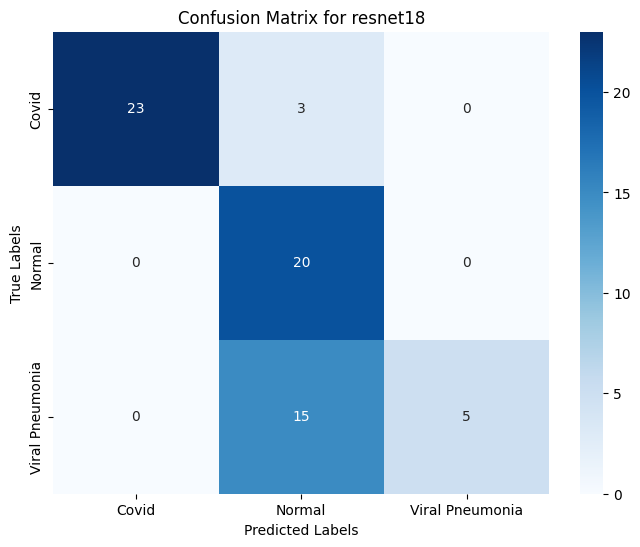

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

def train_and_evaluate(model_name, train_loader, test_loader, device='cuda'):
    print(f"Training {model_name}...")
    model = getattr(models, model_name)(pretrained=True)

    # Modify the classifier for the number of classes
    if 'resnet' in model_name:
        model.fc = nn.Linear(model.fc.in_features, 3)
    elif 'vgg' in model_name:
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, 3)
    elif 'mobilenet' in model_name:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(6):  # limited number of epochs for demonstration
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

    # Evaluate the model
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actuals, predictions)
    report = classification_report(actuals, predictions, output_dict=True)
    print(f'Accuracy of {model_name}: {accuracy:.4f}')
    return model, accuracy, report

# Train multiple models and compare
models_to_test = ['resnet18', 'vgg16', 'mobilenet_v2']
model_results = {}
for model_name in models_to_test:
    model, accuracy, report = train_and_evaluate(model_name, train_loader, test_loader)
    model_results[model_name] = (model, accuracy, report)

# Collect data for the table
data = []
for model_name, (model, accuracy, report) in model_results.items():
    row = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }
    data.append(row)

# Display results in a DataFrame
results_df = pd.DataFrame(data)
results_df = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]
print(results_df)

# Determine the best model based on accuracy
best_model_name = max(model_results, key=lambda x: model_results[x][1])
best_model = model_results[best_model_name][0]
print(f'Best model: {best_model_name} with accuracy {model_results[best_model_name][1]:.4f}')

# Generate the Confusion Matrix for the Best Model
best_model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)

# Define class labels (must match your dataset classes)
class_labels = train_loader.dataset.classes

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix for {best_model_name}')







In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

def train_and_evaluate(model_name, train_loader, test_loader, device='cuda'):
    """
    Train the model and track loss/accuracy for visualization.
    """
    print(f"Training {model_name}...")
    model = getattr(models, model_name)(pretrained=True)

    # Modify classifier based on the model architecture
    if 'resnet' in model_name:
        model.fc = nn.Linear(model.fc.in_features, 3)
    elif 'vgg' in model_name:
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, 3)
    elif 'mobilenet' in model_name:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize lists for tracking loss and accuracy
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training loop
    num_epochs = 4
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        # Compute average loss and accuracy for training
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        # Compute average loss and accuracy for validation
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [41]:
# Train the best model and store loss/accuracy values
best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(best_model_name, train_loader, test_loader)


Training resnet18...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

Epoch 1/4: Train Loss: 0.6653, Train Acc: 0.7012, Val Loss: 9.2102, Val Acc: 0.6364
Epoch 2/4: Train Loss: 0.4826, Train Acc: 0.8486, Val Loss: 5.6666, Val Acc: 0.4848
Epoch 3/4: Train Loss: 0.2037, Train Acc: 0.9522, Val Loss: 3.7591, Val Acc: 0.7424
Epoch 4/4: Train Loss: 0.2152, Train Acc: 0.9163, Val Loss: 3.5427, Val Acc: 0.8333


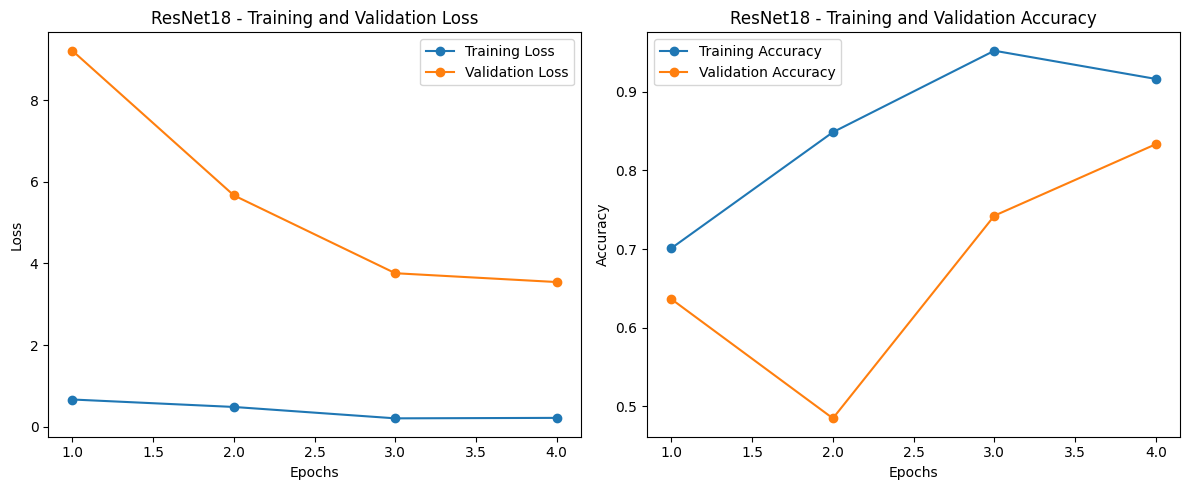

'/mnt/data/best_model_training_curve.png'

In [42]:
import matplotlib.pyplot as plt

def plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies, best_model_name):
    """
    Plots training & validation loss and accuracy curves for the best model.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Training & Validation Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{best_model_name} - Training and Validation Loss")
    plt.legend()

    # Training & Validation Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{best_model_name} - Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plot_path = "/mnt/data/best_model_training_curve.png"

    plt.show()

    return plot_path

    # Define the best model name manually for plotting
best_model_name = "ResNet18"  # Replace with the actual best model name from your training results

# Plot training curve for the best model
best_model_curve_path = plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies, best_model_name)

# Return the path to the saved plot
best_model_curve_path

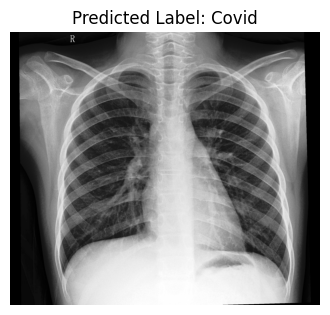

In [43]:
# Function to predict the class of a sample image using the best model
def predict_sample_image(model, test_image_path, class_map):
    model.eval()
    image = Image.open(test_image_path).convert('RGB')
    transformed_image = transform(image).unsqueeze(0).to('cuda')  # Ensure this matches your device setup
    with torch.no_grad():
        output = model(transformed_image)
        predicted_class = torch.argmax(output, dim=1).item()
    predicted_label = class_map[predicted_class]

    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

# Load test data to create class mapping and test image prediction
test_data_path = '/content/dataset/Covid19-dataset/test'  # Ensure this path is correctly set
test_data = datasets.ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Create class mapping
class_map = {value: key for key, value in test_data.class_to_idx.items()}

# Test a sample image using the best model
sample_test_image_path = os.path.join(test_data_path, "Normal/0102.jpeg")  # Ensure the image path is correct
predict_sample_image(best_model, sample_test_image_path, class_map)

In [44]:
from sklearn.model_selection import KFold

def train_model_with_cross_validation(dataset, model_func, k=5, epochs=3, device='cuda'):
    kf = KFold(n_splits=k, shuffle=True)
    results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        test_subset = torch.utils.data.Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

        # Initialize the model
        model = model_func().to(device)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        for epoch in range(epochs):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Fold {fold+1}: Accuracy = {accuracy*100:.2f}%')
        results.append(accuracy)

    print(f'Average Accuracy: {np.mean(results)*100:.2f}%')
    return results

# Example model function for ResNet18
def get_resnet18():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 3)  # Adapting for 3 classes
    return model

# Assuming dataset is properly loaded and preprocessed
# results = train_model_with_cross_validation(dataset, get_resnet18)


In [45]:
import torch

# Define the path where the model will be saved
model_save_path = "/content/best_model.pth"

# Save the model state dictionary
torch.save(best_model.state_dict(), model_save_path)

print(f"Model saved successfully at {model_save_path}")


Model saved successfully at /content/best_model.pth


In [46]:
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2  # Required for resizing the heatmap
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def apply_gradcam(model, img_path, target_layer, device='cuda'):
    """
    Apply Grad-CAM to a given image and model, with proper resizing.
    """
    model.to(device)
    model.eval()

    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resizing for ResNet input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the original image (Keep original size)
    img = Image.open(img_path).convert('RGB')
    original_size = img.size  # Keep original dimensions (W, H)

    # Process the image for model input
    processed_img = transform(img).unsqueeze(0).to(device)

    # Apply Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    cam_mask = cam(input_tensor=processed_img)[0]  # Extract first channel

    # Resize the heatmap to match the original image size
    cam_mask_resized = cv2.resize(cam_mask, original_size)  # Resize to (W, H)

    # Normalize and overlay the Grad-CAM heatmap on the original image
    cam_image = show_cam_on_image(np.array(img) / 255., cam_mask_resized, use_rgb=True)

    # Display the original and Grad-CAM overlay image
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Grad-CAM Image
    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()


<ipython-input-48-91760f250333>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('/content/best_model.pth'))  # Load trained model


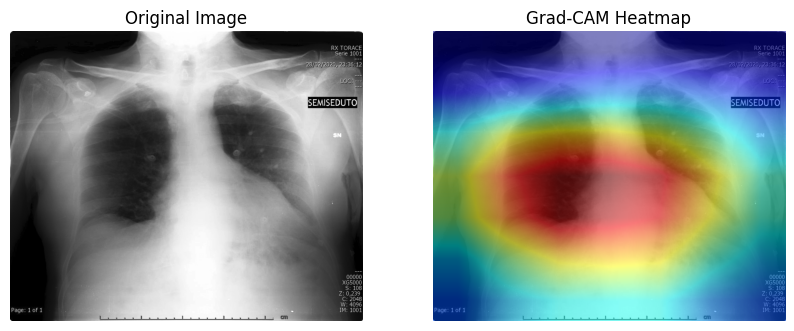

In [48]:
import torch
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load the best model (ResNet18)
best_model = models.resnet18(pretrained=True)
best_model.fc = torch.nn.Linear(best_model.fc.in_features, 3)  # Modify for 3 classes
best_model.load_state_dict(torch.load('/content/best_model.pth'))  # Load trained model
best_model.eval()

# Select the correct target layer for Grad-CAM (for ResNet18)
target_layer = best_model.layer4[-1]  # Last convolutional layer in ResNet18

# Define the path to your test image
test_image_path = "/content/dataset/Covid19-dataset/test/Covid/0118.jpeg"

def apply_gradcam(model, img_path, target_layer, device='cuda'):
    """
    Apply Grad-CAM to a given image and model.
    """
    model.to(device)
    model.eval()

    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    original_size = img.size  # Keep original size
    processed_img = transform(img).unsqueeze(0).to(device)

    # Apply Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    cam_mask = cam(input_tensor=processed_img)[0]

    # Resize the heatmap to match the original image size
    cam_mask_resized = cv2.resize(cam_mask, original_size)

    # Overlay Grad-CAM heatmap on the original image
    cam_image = show_cam_on_image(np.array(img) / 255., cam_mask_resized, use_rgb=True)

    # Display images
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Grad-CAM Image
    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()

# Apply Grad-CAM for ResNet18
apply_gradcam(best_model, test_image_path, target_layer)
